In [1]:
import model_utils as mu
mu.DEATH_RATE = 0.36
mu.ICU_RATE = 0.78
mu.HOSPITAL_RATE = 2.18
mu.SYMPTOM_RATE = 10.2
mu.INFECT_2_HOSPITAL_TIME = 11
mu.HOSPITAL_2_ICU_TIME = 4
mu.ICU_2_DEATH_TIME = 4
mu.ICU_2_RECOVER_TIME = 7
mu.NOT_ICU_DISCHARGE_TIME = 5

In [26]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
daily_metrics, cum_metrics, model_beta = mu.get_metrics_by_country('Iraq', lockdown_date='20200322', relax_date='20200411')

NumExpr defaulting to 4 threads.
C:\Users\Quoc\bitbucket\covid-19\prognosis\model_utils.py:263: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_new)


In [5]:
import plotly.offline as py_offline
import cufflinks as cf
cf.go_offline()
py_offline.__PLOTLY_OFFLINE_INITIALIZED = True

In [6]:
daily_metrics.iplot()

In [101]:
cum_metrics.iplot()

In [7]:
import SEIR

In [100]:
daily_metrics.death['2020/06/01']*100/mu.DEATH_RATE


2777.777777777778

In [36]:
Infected = (100/mu.DEATH_RATE)*daily_metrics.death
relax_date='20200511'
Cases = Infected.cumsum()
#Cases = Cases[Cases.index>=relax_date].dropna()
start_date ='20200420'
C = np.array(Cases.iloc[:])
N = 38430000 # the population of Iraq
r0 = cum_metrics.infected[start_date]
i0=C[0]-r0
I0 = [i0] 
E0 = i0*0.2*range(10)

In [109]:
Cases['2020/06/01']

59166.66666666664

In [33]:
type(Cases)

pandas.core.series.Series

In [180]:
import imp; imp.reload(SEIR)

<module 'SEIR' from 'C:\\Users\\Quoc\\bitbucket\\covid-19\\prognosis\\SEIR.py'>

In [169]:
def predict_cumulative_infected_cases_SEIR(cumulative_infected_cases, N, start_date, C0=None, forecast_horizon=60):
    """
    N: total population
    SEIR is started at the start date with initial cumulative cases is set by C0. 
    If not set, C0 is the observed cumulative cases. This is very different from confirmed cases
    Assumption: initial recovery is equal to cumulative cases at offset_days(19) days ago
    """
    start_date = pd.to_datetime(start_date)
    offset_days = dt.timedelta(mu.INFECT_2_HOSPITAL_TIME + mu.HOSPITAL_2_ICU_TIME + mu.ICU_2_DEATH_TIME)
    Cpast = cumulative_infected_cases[cumulative_infected_cases.index>=start_date].dropna()
    if C0 is None:
        C0 = Cpast[0]
    r0 = cumulative_infected_cases.loc[start_date - offset_days]
    r0 = 0.9*C0 
    print(r0)
    i0 = C0-r0
    E0 = i0*0.2*range(10)
    best = np.inf
    res = (0, 0, 0)
    t = np.arange(len(Cpast))
    for e0 in E0:        
        y0 = [N-e0-i0-r0, e0, i0, r0]
        opt, val = SEIR.minimization(y0, t, Cpast, N, 30)
        if (val < best):
            besty0 = y0
            res = opt
            best = val
        print((e0, i0, best))
    tau = np.arange(len(Cpast)+forecast_horizon)
    out_seir = SEIR.dynamics(besty0, tau, N, *res)
    fitted = out_seir[:,2]+out_seir[:,3]
    date_range = Cpast.index.append(pd.date_range(start=Cpast.index[-1]+dt.timedelta(1), periods=forecast_horizon))
    print(res)
    return pd.DataFrame({'predicted_infected':fitted}, index=date_range)

In [181]:
predicted_cases = predict_cumulative_infected_cases_SEIR(Cases, N, start_date='2020/04/29', forecast_horizon=365)

22499.99999999999


C:\Users\Quoc\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:23: RuntimeWarning:

overflow encountered in exp



(0.0, 2499.9999999999964, 7434475274.637704)
(499.9999999999993, 2499.9999999999964, 7434475274.637704)
(999.9999999999986, 2499.9999999999964, 7434475274.637704)
(1499.999999999998, 2499.9999999999964, 7434475274.637704)
(1999.9999999999973, 2499.9999999999964, 7434475274.637704)
(2499.9999999999964, 2499.9999999999964, 7434475274.637704)
(2999.999999999996, 2499.9999999999964, 7434475274.637704)
(3499.9999999999955, 2499.9999999999964, 7434475274.637704)
(3999.9999999999945, 2499.9999999999964, 7434475274.637704)
(4499.999999999994, 2499.9999999999964, 7434475274.637704)
[  2.76084612  -7.16640927 -29.09700449]


In [182]:
daily_predicted_case = mu.get_daily_data(predicted_cases)

In [183]:
predicted_cases[1:]

,predicted_infected
2020-04-30,2.501526e+04
2020-05-01,2.506118e+04
2020-05-02,2.513827e+04
2020-05-03,2.524741e+04
2020-05-04,2.538987e+04
...,...
2021-07-15,1.016155e+07
2021-07-16,1.018337e+07
2021-07-17,1.020517e+07
2021-07-18,1.022695e+07


In [184]:
daily_predicted_case[1:].head()

,predicted_infected
2020-04-30,15.257949
2020-05-01,45.923152
2020-05-02,77.092073
2020-05-03,109.141727
2020-05-04,142.457829


In [185]:
log_daily_predicted_case = np.log(daily_predicted_case[1:]*(mu.DEATH_RATE/100))

In [186]:
log_daily_predicted_case.head()

,predicted_infected
2020-04-30,-2.901721
2020-05-01,-1.799852
2020-05-02,-1.281821
2020-05-03,-0.934174
2020-05-04,-0.667775


In [187]:
log_fit, params = mu.get_log_daily_predicted_death_by_country('Iraq', lockdown_date='20200322', relax_date='20200411')

C:\Users\Quoc\bitbucket\covid-19\prognosis\model_utils.py:458: RuntimeWarning:

divide by zero encountered in log

C:\Users\Quoc\bitbucket\covid-19\prognosis\model_utils.py:263: RuntimeWarning:

divide by zero encountered in log



In [188]:
sum(params[1:])

0.07019206117982296

In [189]:
log_fit.merge(log_daily_predicted_case, left_index=True, right_index=True, how='left').iplot()

In [126]:
log_fit.merge(log_daily_predicted_case, left_index=True, right_index=True, how='left').iplot()

In [108]:
log_fit.merge(log_daily_predicted_case, left_index=True, right_index=True, how='left').iplot()

In [95]:
log_fit.merge(log_daily_predicted_case, left_index=True, right_index=True, how='left').iplot()

In [85]:
log_fit.merge(log_daily_predicted_case, left_index=True, right_index=True, how='left').iplot()

In [190]:
mu.get_daily_data(predicted_cases).merge(mu.get_daily_data(Cases), left_index=True, right_index=True, how='left').iplot()

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:20: RuntimeWarning:

overflow encountered in exp



(0.0, 3786.10230978666, 47600159.764799684)
(757.2204619573321, 3786.10230978666, 46433653.4772195)
(1514.4409239146642, 3786.10230978666, 46433653.4772195)
(2271.661385871996, 3786.10230978666, 46433653.4772195)
(3028.8818478293283, 3786.10230978666, 46433653.4772195)
(3786.1023097866605, 3786.10230978666, 46433653.4772195)
(4543.322771743992, 3786.10230978666, 46433653.4772195)
(5300.543233701324, 3786.10230978666, 46433653.4772195)
(6057.763695658657, 3786.10230978666, 46433653.4772195)
(6814.984157615989, 3786.10230978666, 46433653.4772195)
(7572.204619573321, 3786.10230978666, 46433653.4772195)
(8329.425081530653, 3786.10230978666, 46433653.4772195)
(9086.645543487984, 3786.10230978666, 46433653.4772195)
(9843.866005445318, 3786.10230978666, 46433653.4772195)
(10601.086467402649, 3786.10230978666, 46433653.4772195)
(11358.306929359982, 3786.10230978666, 46433653.4772195)
(12115.527391317313, 3786.10230978666, 46433653.4772195)
(12872.747853274645, 3786.10230978666, 46433653.477219

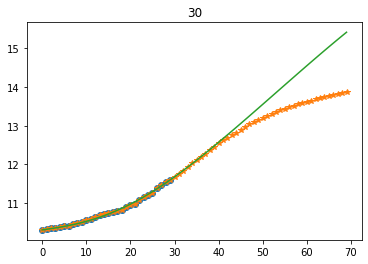

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



(0.0, 3786.10230978666, 73311256.69698794)
(757.2204619573321, 3786.10230978666, 72255793.83910647)
(1514.4409239146642, 3786.10230978666, 72255793.83910647)
(2271.661385871996, 3786.10230978666, 72255793.83910647)
(3028.8818478293283, 3786.10230978666, 72255793.83910647)
(3786.1023097866605, 3786.10230978666, 72255793.83910647)
(4543.322771743992, 3786.10230978666, 72255793.83910647)
(5300.543233701324, 3786.10230978666, 72255793.83910647)


C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:20: RuntimeWarning:

overflow encountered in exp



(6057.763695658657, 3786.10230978666, 72255793.83910647)
(6814.984157615989, 3786.10230978666, 72255793.83910647)
(7572.204619573321, 3786.10230978666, 72255793.83910647)
(8329.425081530653, 3786.10230978666, 72255793.83910647)
(9086.645543487984, 3786.10230978666, 72255793.83910647)
(9843.866005445318, 3786.10230978666, 72255793.83910647)
(10601.086467402649, 3786.10230978666, 72255793.83910647)
(11358.306929359982, 3786.10230978666, 72255793.83910647)
(12115.527391317313, 3786.10230978666, 72255793.83910647)
(12872.747853274645, 3786.10230978666, 72255793.83910647)
(13629.968315231978, 3786.10230978666, 72255793.83910647)
(14387.188777189309, 3786.10230978666, 72255793.83910647)


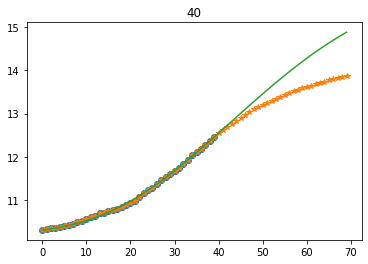

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:20: RuntimeWarning:

overflow encountered in exp

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



(0.0, 3786.10230978666, 703053535.5054384)
(757.2204619573321, 3786.10230978666, 701010024.1939857)
(1514.4409239146642, 3786.10230978666, 701010024.1939857)
(2271.661385871996, 3786.10230978666, 369012554.3289691)
(3028.8818478293283, 3786.10230978666, 369012554.3289691)
(3786.1023097866605, 3786.10230978666, 369012554.3289691)
(4543.322771743992, 3786.10230978666, 369012554.3289691)
(5300.543233701324, 3786.10230978666, 369012554.3289691)
(6057.763695658657, 3786.10230978666, 369012554.3289691)
(6814.984157615989, 3786.10230978666, 369012554.3289691)


C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:23: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:24: RuntimeWarning:

overflow encountered in double_scalars



(7572.204619573321, 3786.10230978666, 369012554.3289691)
(8329.425081530653, 3786.10230978666, 369012554.3289691)
(9086.645543487984, 3786.10230978666, 369012554.3289691)
(9843.866005445318, 3786.10230978666, 369012554.3289691)
(10601.086467402649, 3786.10230978666, 369012554.3289691)
(11358.306929359982, 3786.10230978666, 369012554.3289691)
(12115.527391317313, 3786.10230978666, 369012554.3289691)
(12872.747853274645, 3786.10230978666, 369012554.3289691)
(13629.968315231978, 3786.10230978666, 369012554.3289691)
(14387.188777189309, 3786.10230978666, 369012554.3289691)


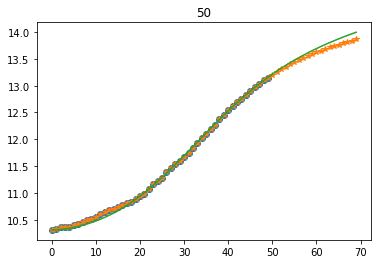

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Quoc\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.



(0.0, 3786.10230978666, 584580674.1485335)


C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:20: RuntimeWarning:

overflow encountered in exp



(757.2204619573321, 3786.10230978666, 584580674.1485335)
(1514.4409239146642, 3786.10230978666, 583726225.9229888)
(2271.661385871996, 3786.10230978666, 583726225.9229888)
(3028.8818478293283, 3786.10230978666, 583726225.9229888)
(3786.1023097866605, 3786.10230978666, 583726225.9229888)
(4543.322771743992, 3786.10230978666, 583726225.9229888)


C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:23: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Quoc\bitbucket\covid-19\prognosis\SEIR.py:24: RuntimeWarning:

overflow encountered in double_scalars



(5300.543233701324, 3786.10230978666, 583726225.9229888)
(6057.763695658657, 3786.10230978666, 583726225.9229888)
(6814.984157615989, 3786.10230978666, 583726225.9229888)
(7572.204619573321, 3786.10230978666, 580292520.3714516)
(8329.425081530653, 3786.10230978666, 579861572.9389634)
(9086.645543487984, 3786.10230978666, 579861572.9389634)
(9843.866005445318, 3786.10230978666, 579861572.9389634)
(10601.086467402649, 3786.10230978666, 578566347.5245951)
(11358.306929359982, 3786.10230978666, 578133873.4039221)
(12115.527391317313, 3786.10230978666, 578133873.4039221)
(12872.747853274645, 3786.10230978666, 578133873.4039221)
(13629.968315231978, 3786.10230978666, 578133873.4039221)
(14387.188777189309, 3786.10230978666, 578133873.4039221)


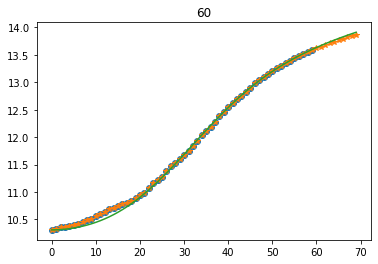

In [21]:
for n_data_point in [30, 40, 50, 60]:
    Cpast = C[0:n_data_point]

    best = np.inf
    res = (0, 0, 0)
    t = np.arange(len(Cpast))

    for e0 in E0:
        for i0 in I0:    
            y0 = [N-e0-i0-r0, e0, i0, r0]
            opt, val = SEIR.minimization(y0, t, Cpast, N, 50)
            if (val < best):
                besty0 = y0
                res = opt
                best = val
            print((e0, i0, best))

    tau = np.arange(len(C))
    out_seir = SEIR.dynamics(besty0, tau, N, *res)
    fitted = out_seir[:,2]+out_seir[:,3]
    plt.plot(t, np.log(Cpast), 'o')
    plt.plot(tau, np.log(C), '*')
    plt.plot(tau, np.log(fitted))
    plt.title('{}'.format(n_data_point))
    plt.show()

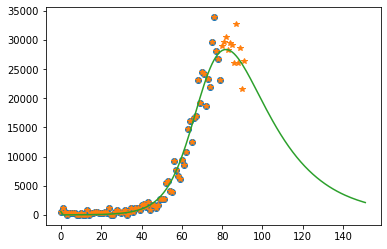

In [58]:
plt.plot(t, Ipast, 'o')
plt.plot(tau, I, '*')
plt.plot(tau, fitted)
plt.show()